In [58]:
import keras 
import numpy as np
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten, GlobalAveragePooling1D, LSTM, Reshape
from keras.models import Model, Sequential
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [2]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [23]:
train_data = pd.read_csv('text_emotion.csv')

In [24]:
train_data.head()

sentiment                                            content
0       joy  [ On days when I feel close to my partner and ...
1      fear  Every time I imagine that someone I love or I ...
2     anger  When I had been obviously unjustly treated and...
3   sadness  When I think about the short time that we live...
4   disgust  At a gathering I found myself involuntarily si...

In [26]:
train_data['target'] = train_data.sentiment.astype('category').cat.codes

In [28]:
train_data['num_words'] = train_data.content.apply(lambda x : len(x.split()))

In [29]:
bins=[0,50,75, np.inf]
train_data['bins']=pd.cut(train_data.num_words, bins=[0,100,300,500,800, np.inf], labels=['0-100', '100-300', '300-500','500-800' ,'>800'])

In [30]:
word_distribution = train_data.groupby('bins').size().reset_index().rename(columns={0:'counts'})

In [31]:
word_distribution.head()

bins  counts
0    0-100    7630
1  100-300      22
2  300-500       0
3  500-800       0
4     >800       0

Text(0.5, 1.0, 'Word distribution per bin')

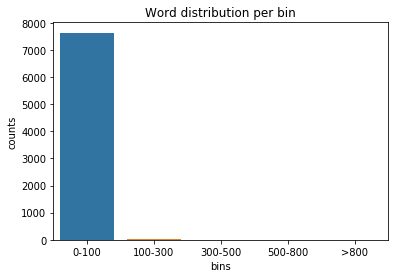

In [32]:
sns.barplot(x='bins', y='counts', data=word_distribution).set_title("Word distribution per bin")

In [38]:
num_class = len(np.unique(train_data.sentiment.values))
y = train_data['target'].values
num_class

7

In [39]:
MAX_LENGTH = 100
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.content.values)
post_seq = tokenizer.texts_to_sequences(train_data.content.values)
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.05)
y_train

array([6, 1, 3, ..., 3, 6, 0], dtype=int8)

In [41]:
vocab_size = len(tokenizer.word_index) + 1

In [72]:
inputs = Input(shape=(MAX_LENGTH, ))
embedding_layer = Embedding(vocab_size,
                            128,
                            input_length=MAX_LENGTH)(inputs)

# x = Flatten()(embedding_layer)
# x = LSTM(32, return_sequences=True, input_shape=(MAX_LENGTH, 32, 32))
x = LSTM(32, input_shape=(32, 32))(embedding_layer)
# x = Reshape((32, 1,))(x)
# x = LSTM(32)(x)
x = Dense(32, activation='relu')(x)

predictions = Dense(num_class, activation='softmax')(x)
model = Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()
filepath="weights-simple.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit([X_train], batch_size=128, y=to_categorical(y_train), verbose=1, validation_split=0.05, 
          shuffle=True, epochs=5, callbacks=[checkpointer])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 100)               0         
_________________________________________________________________
embedding_29 (Embedding)     (None, 100, 128)          1171840   
_________________________________________________________________
lstm_31 (LSTM)               (None, 32)                20608     
_________________________________________________________________
dense_33 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_34 (Dense)             (None, 7)                 231       
Total params: 1,193,735
Trainable params: 1,193,735
Non-trainable params: 0
_________________________________________________________________
Train on 6905 samples, validate on 364 samples
Epoch 1/5
6905/6905 [==============================] - 8s 1ms/step - loss: 1.9323 - a

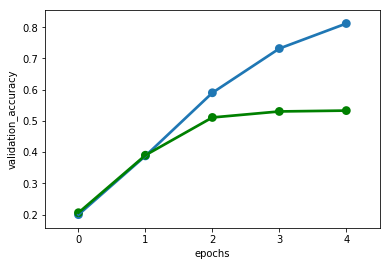

In [49]:
df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')

In [50]:
predicted = model.predict(X_test)
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

0.5352480417754569

In [51]:
predicted

array([4, 2, 4, 1, 0, 1, 5, 5, 6, 0, 6, 5, 4, 2, 2, 4, 2, 3, 3, 1, 6, 2,
       4, 1, 4, 6, 2, 0, 4, 1, 6, 6, 1, 1, 0, 3, 4, 2, 2, 2, 0, 1, 4, 0,
       3, 0, 4, 5, 2, 6, 4, 1, 1, 0, 2, 2, 4, 5, 4, 5, 2, 1, 5, 2, 4, 2,
       4, 5, 0, 6, 1, 6, 3, 1, 2, 1, 1, 1, 1, 5, 5, 3, 1, 0, 3, 2, 4, 2,
       6, 6, 2, 0, 4, 5, 1, 1, 1, 3, 0, 1, 5, 3, 4, 1, 0, 1, 6, 6, 5, 2,
       1, 1, 0, 3, 5, 3, 6, 0, 0, 1, 3, 0, 3, 2, 2, 3, 1, 6, 1, 6, 1, 5,
       2, 2, 5, 0, 3, 0, 1, 6, 6, 3, 3, 2, 1, 5, 4, 6, 0, 5, 4, 2, 0, 4,
       6, 3, 6, 3, 5, 2, 2, 2, 1, 0, 6, 0, 4, 5, 1, 2, 6, 1, 0, 6, 1, 1,
       3, 6, 1, 5, 6, 6, 0, 2, 4, 1, 5, 4, 4, 5, 6, 3, 4, 4, 5, 0, 6, 4,
       1, 5, 4, 5, 5, 6, 5, 2, 6, 2, 2, 0, 6, 4, 2, 2, 6, 3, 6, 2, 6, 5,
       1, 1, 5, 5, 1, 0, 6, 2, 0, 1, 6, 3, 5, 5, 5, 3, 1, 5, 2, 1, 1, 6,
       0, 5, 6, 1, 5, 0, 1, 5, 2, 6, 3, 2, 6, 6, 6, 1, 2, 5, 4, 0, 2, 2,
       1, 2, 2, 4, 5, 6, 5, 1, 1, 5, 0, 3, 4, 1, 1, 4, 1, 2, 0, 3, 3, 6,
       3, 6, 1, 0, 2, 2, 4, 2, 6, 3, 3, 5, 6, 5, 2,

In [52]:
y_test

array([6, 0, 4, 0, 1, 1, 5, 4, 6, 0, 3, 5, 4, 2, 5, 4, 2, 3, 3, 3, 1, 2,
       4, 6, 2, 1, 2, 1, 3, 1, 6, 3, 6, 5, 0, 0, 2, 2, 2, 0, 3, 1, 4, 0,
       3, 3, 4, 5, 2, 6, 4, 0, 0, 1, 3, 2, 5, 5, 6, 5, 2, 0, 4, 2, 4, 2,
       6, 2, 0, 1, 3, 6, 3, 2, 0, 1, 2, 1, 0, 5, 5, 0, 0, 2, 3, 4, 4, 2,
       1, 6, 2, 0, 4, 0, 1, 1, 2, 3, 1, 1, 3, 2, 4, 1, 4, 1, 6, 6, 0, 2,
       1, 6, 0, 3, 4, 6, 3, 3, 6, 0, 6, 3, 3, 2, 2, 3, 0, 0, 0, 6, 0, 5,
       2, 5, 5, 0, 5, 5, 1, 6, 6, 0, 3, 3, 1, 5, 4, 6, 0, 5, 4, 5, 0, 4,
       6, 1, 3, 3, 0, 2, 2, 6, 1, 0, 6, 6, 4, 5, 6, 2, 1, 1, 3, 1, 3, 1,
       3, 6, 1, 0, 6, 3, 0, 2, 0, 1, 5, 1, 4, 4, 0, 3, 5, 4, 5, 0, 6, 2,
       1, 5, 1, 5, 5, 6, 2, 1, 0, 2, 2, 0, 6, 6, 2, 2, 3, 3, 0, 3, 6, 6,
       1, 1, 6, 4, 0, 0, 6, 2, 1, 3, 1, 3, 5, 5, 5, 6, 1, 5, 2, 1, 2, 4,
       1, 5, 1, 3, 6, 6, 1, 5, 2, 4, 5, 2, 0, 6, 6, 0, 3, 3, 3, 3, 2, 2,
       1, 4, 0, 4, 3, 0, 5, 6, 4, 5, 0, 3, 3, 1, 1, 6, 1, 1, 0, 3, 3, 6,
       3, 4, 5, 3, 2, 2, 4, 1, 1, 2, 6, 1, 6, 2, 2,